# Used Cars pricing using RandomForestRegressor (Kaggle dataset)

TODO:
- transform and scale new data for prediction after the model has been saved
- isolate new data predictions from the model building code

In [120]:
# Display plots inline in the notebook
%matplotlib inline

# upgrade scikit-learn and xgboost to the latest
#!pip install --upgrade scikit-learn xgboost

# Import core libraries
import pandas as pd
import numpy as np
#matplotlib.use('Agg')  # Use 'Agg' backend for non-GUI environments
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# stats libraries
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as sf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

import joblib  # Use joblib to save and load the model
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('used_cars.csv')

# This record added so it can be transformed with the rest of the
# data set, then removed before training. It was used for prediction
# after the model was trained.
new_data = pd.DataFrame({
    'brand': ['Toyota'],
    'model': ['Tacoma TRD Sport'],
    'model_year': [2019],
    'milage': ['86000 mi.'],
    'fuel_type': ['Gasoline'],
    'engine': ['275HP'],
    'transmission': ['Automatic'],
    'ext_col': ['Blue'],
    'int_col': ['Gray'],
    'accident': ['None reported'],
    'clean_title': ['Yes'],
    'price': [40000]
})
# Append the Tacoma data to the original data
data = pd.concat([data, new_data], ignore_index=True)

print("Last 5 records of the dataset:")
print(data.tail())



Last 5 records of the dataset:
        brand                 model  model_year      milage fuel_type  \
4005     Audi  S4 3.0T Premium Plus        2022  10,900 mi.  Gasoline   
4006  Porsche                Taycan        2022   2,116 mi.       NaN   
4007     Ford          F-150 Raptor        2020  33,000 mi.  Gasoline   
4008      BMW          X3 xDrive30i        2020  43,000 mi.  Gasoline   
4009   Toyota      Tacoma TRD Sport        2019   86000 mi.  Gasoline   

                                             engine  \
4005  349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
4006                                       Electric   
4007  450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel   
4008   248.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
4009                                          275HP   

                        transmission ext_col int_col  \
4005  Transmission w/Dual Shift Mode   Black   Black   
4006                       Automatic   Black   Black   
4007                           

### Get basic dataset info

In [121]:
# Get basic info
print(data.info())

print("\nMissing values in each column:")
print(data.isnull().sum())

# Check for duplicates
#print(data.duplicated().sum())

print("\nStatistical summary of numerical features:")
print(data.describe())

# find unique fuel_types
print("\nUnique fuel types:")
print(data['fuel_type'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4010 entries, 0 to 4009
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4010 non-null   object
 1   model         4010 non-null   object
 2   model_year    4010 non-null   int64 
 3   milage        4010 non-null   object
 4   fuel_type     3840 non-null   object
 5   engine        4010 non-null   object
 6   transmission  4010 non-null   object
 7   ext_col       4010 non-null   object
 8   int_col       4010 non-null   object
 9   accident      3897 non-null   object
 10  clean_title   3414 non-null   object
 11  price         4010 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.1+ KB
None

Missing values in each column:
brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title    

### Data Cleaning and Preprocessing

In [122]:
# Step 3: Data cleaning and Preprocessing

def clean_milage(df):
    # Clean the milage field
    df['milage'] = df['milage'].str.replace('"', '')      # Remove double quotes
    df['milage'] = df['milage'].str.replace(' mi.', '')   # Remove ' mi.' from the end
    df['milage'] = df['milage'].str.replace(',', '')      # Remove commas
    # Convert to numeric
    df['milage'] = pd.to_numeric(df['milage'], errors='coerce')
    # Replace any missing values with the median
    df['milage'] = df['milage'].fillna(df['milage'].median())
    return df

data = clean_milage(data)

# Check for missing values in milage
#missing_milage = data['milage'].isnull().sum()
#print()
#print(f"Number of missing milage values: {missing_milage}")

def clean_price(df):
    # Clean the price field
    df['price'] = df['price'].str.replace('"', '')  # Remove double quotes
    df['price'] = df['price'].str.replace('$', '')  # Remove dollar signs
    df['price'] = df['price'].str.replace(',', '')  # Remove commas
    # Convert to numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    # Replace any missing values with the median
    df['price'] = df['price'].fillna(df['price'].median())
    return df

data = clean_price(data)

# Check for missing values in price
#missing_price = data['price'].isnull().sum()
#print()
#print(f"Number of missing price values: {missing_price}")

def create_age(df):
    # Create 'Age' feature
    # This is a more useful representation than using the model year
    current_year = 2024
    df['age'] = current_year - df['model_year']
    # drop the original model_year column
    df = data.drop('model_year', axis=1)
    return df

data = create_age(data)

# Handle missing values: fuel_type, accident, and clean_title

def clean_fuel_type(df):
    # Clean fuel_type
    # Replace 'not supported' with 'Hydrogen' (after inspection)
    df['fuel_type'] = df['fuel_type'].str.replace('not supported', 'Hydrogen')
    # Replace missing with 'Electric' (after inspection)
    df['fuel_type'] = df['fuel_type'].fillna('Electric')
    # Replace anything else with 'Gasoline'
    df['fuel_type'] = df['fuel_type'].str.replace(r'^[^a-zA-Z]', 'Gasoline', regex=True)
    return df

data = clean_fuel_type(data)

def clean_accident(df):
    # Clean accident
    # Replace missing with 'None reported'
    df['accident'] = df['accident'].fillna('None reported')
    return df

data = clean_accident(data)

def clean_engine(df):
    # Clean engine
    # Extract horsepower value as a string
    # note: many don't have HP, but do have engine size that could
    # be extracted as a new feature
    df['engine_hp_str'] = df['engine'].str.extract(r'(\d+\.?\d*)HP')
    # Convert the extracted horsepower strings to float
    df['engine_hp'] = pd.to_numeric(df['engine_hp_str'], errors='coerce')

    #print("\nMissing engine_hp values:")
    #print(data[data['engine_hp'].isnull()])

    return df

data = clean_engine(data)

# Drop the intermediate string column and the original engine feature
data = data.drop(columns=['engine', 'engine_hp_str'])
# Replace missing values with the median sedan HP (web search)
data['engine_hp'] = data['engine_hp'].fillna(200)

# Check for missing values in engine_hp
#missing_hp = data['engine_hp'].isnull().sum()
#print()
#print(f"Number of missing horsepower values: {missing_hp}")

def clean_transmission(df):
    # Clean Transmission
    # Initialize the 'transmission_clean' column with 'Automatic'
    df['transmission_clean'] = 'Automatic'
    # Assign 'Automatic' where condition 1 is met
    df.loc[df['transmission'].str.contains(r'A/T|Automatic', case=False, na=False), 'transmission_clean'] = 'Automatic'
    # Assign 'Manual' where condition 2 is met
    df.loc[df['transmission'].str.contains(r'M/T|Manual', case=False, na=False), 'transmission_clean'] = 'Manual'
    # Drop the original transmission feature
    df = df.drop(columns=['transmission'])
    return df

data = clean_transmission(data)

def clean_title(df):
    # Clean title
    # Replace missing with 'No'
    df['clean_title'] = df['clean_title'].fillna('No')
    return df

data = clean_title(data)

# Check for missing values in transmission_clean
#missing_transmission = data['transmission_clean'].isnull().sum()
#print()
#print(f"Number of missing transmission values: {missing_transmission}")

# IQR DID NOT IMPROVE THE MODEL SO COMMENTING OUT
# Scale the prices using IQR
# Calculate Q1, Q3, and IQR
#Q1 = data['price'].quantile(0.25)
#Q3 = data['price'].quantile(0.75)
#IQR = Q3 - Q1
# Normalize using the IQR method
#data['price'] = (data['price'] - Q1) / IQR

#print()
#print("Prices normalized with IQR")
#print(data['price'].head(10))

# Remove outliers from 'price' and 'milage'
# The model improved on mean absolute error and R-squared compared to
# leaving outliers in the dataset.
data = data[(data['price'] < data['price'].quantile(0.99)) &
            (data['milage'] < data['milage'].quantile(0.99))]

# Since interior color and exterior color have the lowest effect on price,
# drop them to simplify the model. This showed a very slight improvement
# in metrics.
data = data.drop(columns=['int_col', 'ext_col'])

print()
print("Statistical summary of numerical features:")
print(data.describe())

print("Value counts:")
print()
print(data['brand'].value_counts())
print()
print(data['fuel_type'].value_counts())
print()
print(data['accident'].value_counts())
print()
print(data['clean_title'].value_counts())

print("\nData after feature engineering:")
print(data.tail())




Statistical summary of numerical features:
              milage          price          age    engine_hp
count    3928.000000    3928.000000  3928.000000  3928.000000
mean    63339.884420   39848.936354     8.414715   305.811100
std     48432.914505   34876.555295     6.020791   120.556157
min       100.000000    2000.000000     0.000000    70.000000
25%     23422.500000   17500.000000     4.000000   200.000000
50%     52887.500000   31000.000000     7.000000   285.000000
75%     93000.000000   49500.000000    12.000000   381.250000
max    220450.000000  269991.000000    50.000000  1020.000000
Value counts:

brand
Ford             374
BMW              374
Mercedes-Benz    312
Chevrolet        289
Audi             200
Porsche          195
Toyota           190
Lexus            161
Jeep             143
Land             130
Nissan           115
Cadillac         105
RAM               91
GMC               88
Tesla             87
Dodge             84
Kia               76
Hyundai           72

## Visualizations

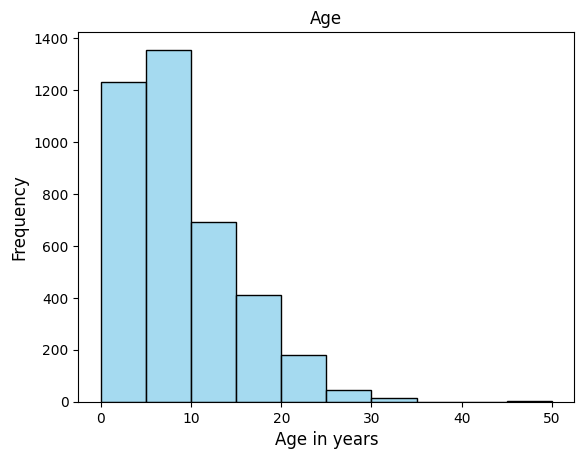

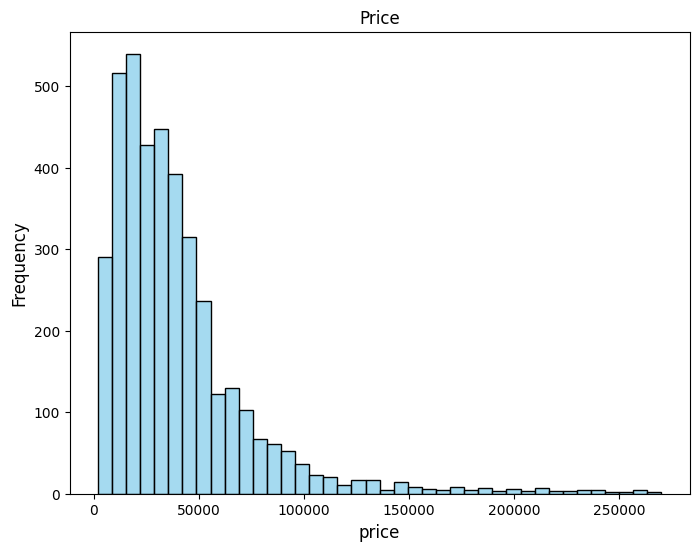

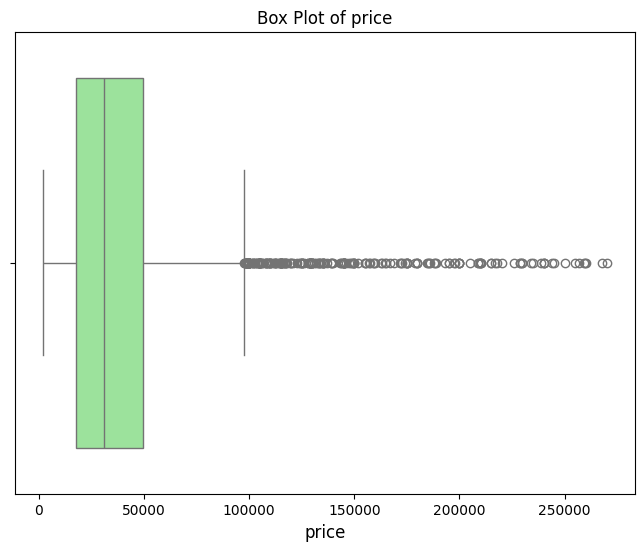

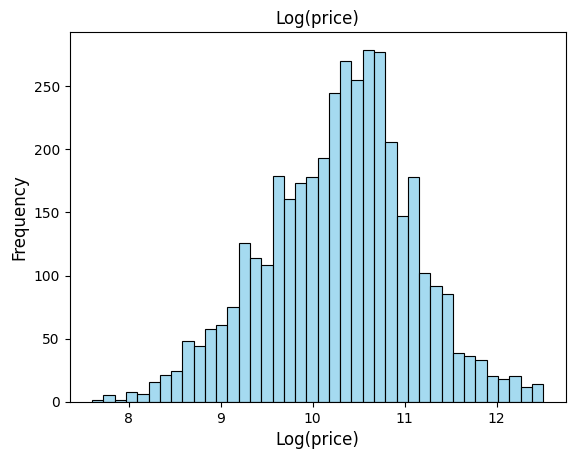

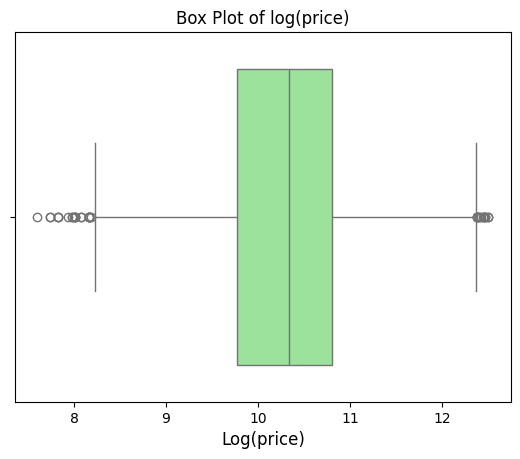

In [123]:
# Visualizations

# Create a histogram of Age
sns.histplot(data['age'], bins=10, color='skyblue', edgecolor='black')
# Add titles and labels
plt.title('Age')
plt.xlabel('Age in years', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


# Histogram of price
plt.figure(figsize=(8, 6))
sns.histplot(data['price'], bins=40, color='skyblue', edgecolor='black')
plt.title('Price')
plt.xlabel('price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Configure x-axis to avoid scientific notation
#ax = plt.gca()
#ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# Ensure the style is plain (non-scientific)
#ax.ticklabel_format(style='plain', axis='x')

# Boxplot of price
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['price'], color='lightgreen')
plt.title('Box Plot of price', fontsize=12)
plt.xlabel('price', fontsize=12)
plt.show()


def log_price(df):
    # Apply log transformation to 'price' to handle skewness
    df['price'] = np.log1p(df['price'])  # log(1 + price)
    return df

data = log_price(data)

# Print first 10 prices after transform
#print("\n")
#print(data['price'].head(10))

# Create a histogram of log(price)
sns.histplot(data['price'], bins=40, color='skyblue', edgecolor='black')
plt.title('Log(price)')
plt.xlabel('Log(price)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Configure x-axis to avoid scientific notation
#ax = plt.gca()
#ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# Ensure the style is plain (non-scientific)
#ax.ticklabel_format(style='plain', axis='x')

# Boxplot of log(price)
sns.boxplot(x=data['price'], color='lightgreen')
plt.title('Box Plot of log(price)', fontsize=12)
plt.xlabel('Log(price)', fontsize=12)
plt.show()

# For linear regression, we don't need to use one-hot encoding
#def one_hot_categeoricals(df):
    # Handle categorical variables with One-Hot Encoding
    #categorical_cols = ['brand', 'model', 'fuel_type', 'transmission_clean', 'ext_col', 'int_col', 'accident', 'clean_title']
#    categorical_cols = ['brand', 'model', 'fuel_type', 'transmission_clean', 'accident', 'clean_title']
#    df = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
#    return df

#data = one_hot_categeoricals(data)

### Feature scaling and initial correlation analysis


In [124]:
# Feature Selection (target is price)
#X = data.drop(['price'], axis=1)
#y = data['price']

# Feature Scaling (can't scale categorical features)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Save the fitted scaler for later use
#joblib.dump(scaler, 'scaler.pkl')

# Strip the last row (Tacoma) after scaling for later prediction
tacoma_data = data.iloc[[-1]]  # Use iloc to select the last row
# reset index for later prediction
tacoma_data = tacoma_data.reset_index(drop=True)

#tacoma_data_scaled = X[-1].reshape(1, -1)
# Now, drop it so it is not included in training or testing
data = data[:-1]
# Also need to drop the price for the Tacoma so the number of rows matches
#y = y[:-1]

# Linear Correlation Analysis
#data_scaled = pd.DataFrame(X, columns=X.columns)
#data_scaled_price = data_scaled
#data_scaled_price['Price'] = y

#corr_matrix = data_scaled_price.corr()
#print("\nCorrelation of features with Price:")
#print(corr_matrix['Price'].sort_values(ascending=False))

print(data.tail())
print()
print(tacoma_data)

              brand                 model  milage fuel_type  \
4003  Mercedes-Benz  E-Class E 300 4MATIC   53705  Gasoline   
4005           Audi  S4 3.0T Premium Plus   10900  Gasoline   
4006        Porsche                Taycan    2116  Electric   
4007           Ford          F-150 Raptor   33000  Gasoline   
4008            BMW          X3 xDrive30i   43000  Gasoline   

                                    accident clean_title      price  age  \
4003  At least 1 accident or damage reported         Yes  10.162037    6   
4005                           None reported         Yes  10.894904    2   
4006                           None reported          No  11.418604    2   
4007                           None reported         Yes  11.050890    4   
4008  At least 1 accident or damage reported         Yes  10.596660    4   

      engine_hp transmission_clean  
4003      241.0          Automatic  
4005      349.0          Automatic  
4006      200.0          Automatic  
4007      450.0 

### Build a multiple regression model and make predictions

In [125]:
# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the OLS formula.
ols_formula = "price ~ milage + engine_hp + age + C(brand) + C(model) + C(fuel_type) + C(accident) + C(clean_title) + C(transmission_clean)"

# Create an OLS model.
OLS = sf.ols(formula = ols_formula, data = data)

# Fit the model.
model = OLS.fit()

# Save the results summary.
summary = model.summary()

# Display the model results.
print(summary)

# Note: I started with a Random Forest Regressor, but found that XGBRegressor
# producted a better model. Finally, I added a grid search to improve
# the XGBRegressor hyperparameters. Then, I ran into a compatability issue
# with xgboost library, so went back to random forest as a demo.



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     35.09
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:13:51   Log-Likelihood:                 2178.4
No. Observations:                3927   AIC:                            -606.9
Df Residuals:                    2052   BIC:                         1.116e+04
Df Model:                        1874                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Predictions

In [128]:
# Predict the price of the Tacoma

predicted_log_price = model.predict(tacoma_data)
predicted_price = np.expm1(predicted_log_price)

#Print(f"Predicted log price for the Tacoma: {predicted_log_price[0]}")
print(f"Predicted price for the Tacoma: #{predicted_price[0]:.2f}")


Predicted price for the Tacoma: 33611.73
